### Imports

In [2]:
import random
import mysql.connector
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from astropy.modeling import models, fitting
from scipy.stats import normaltest
from sklearn.metrics import mean_squared_error
from astropy.stats import akaike_info_criterion_lsq
from tabulate import tabulate

### Single signal visualization from csv

In [37]:
# Manually find number of points in a signal
file = 'mangaHI-7972-3701.csv'
timeSeries = pd.read_csv(file, names=['vHI', 'fHI', 'fBHI'])

time = timeSeries[22:-1].copy()
time[['vHI', 'fHI', 'fBHI']] = time['vHI'].str.split(expand=True)
time = time.reset_index(drop=True).astype(float)

signal = time['vHI'].values

num_points = len(signal)
print(f"Signal has {num_points} points.")


Signal has 948 points.


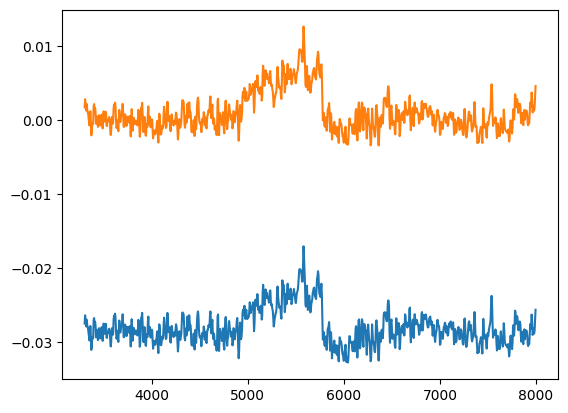

In [3]:
file = 'mangaHI-7443-1902.csv'

timeSeries = pd.read_csv(file, names = ('vHI','fHI', 'fBHI'))

time = timeSeries[22:-1].copy()
time[['vHI','fHI','fBHI']] = time['vHI'].str.split(expand=True)
time = time.reset_index(drop=True).astype(float)

plt.plot(time['vHI'], time['fBHI'])
plt.plot(time['vHI'], time['fHI'])

plt.show()

### Manually select a csv file, perform gaussian fitting and error estimation

Data can't be described by a single Gaussian fit -> using a double Gaussian fit

--- Spectral line region SNR Calculations ---
SNR (Mean Signal value / Mean Noise value) : 25.82 dB
SNR (Average of SNR calculated at each point): 0.54 dB

--- Noise Statistics (Residuals) ---
+----------------------------------------------+-----------+
|                    Metric                    |   Value   |
+----------------------------------------------+-----------+
|    Spectral Line Region (Residuals) Mean     | -0.000034 |
|   Spectral Line Region (Residuals) Std Dev   | 0.001019  |
|  Non-Spectral Line Region (Residuals) Mean   | 0.000063  |
| Non-Spectral Line Region (Residuals) Std Dev | 0.001202  |
|          % Diff in Mean (Residuals)          | -154.27%  |
|        % Diff in Std Dev (Residuals)         |  -15.24%  |
+----------------------------------------------+-----------+

--- MSE and RMSE Comparisons ---
+---------------------------+------------+
|          Metric           |   Value  

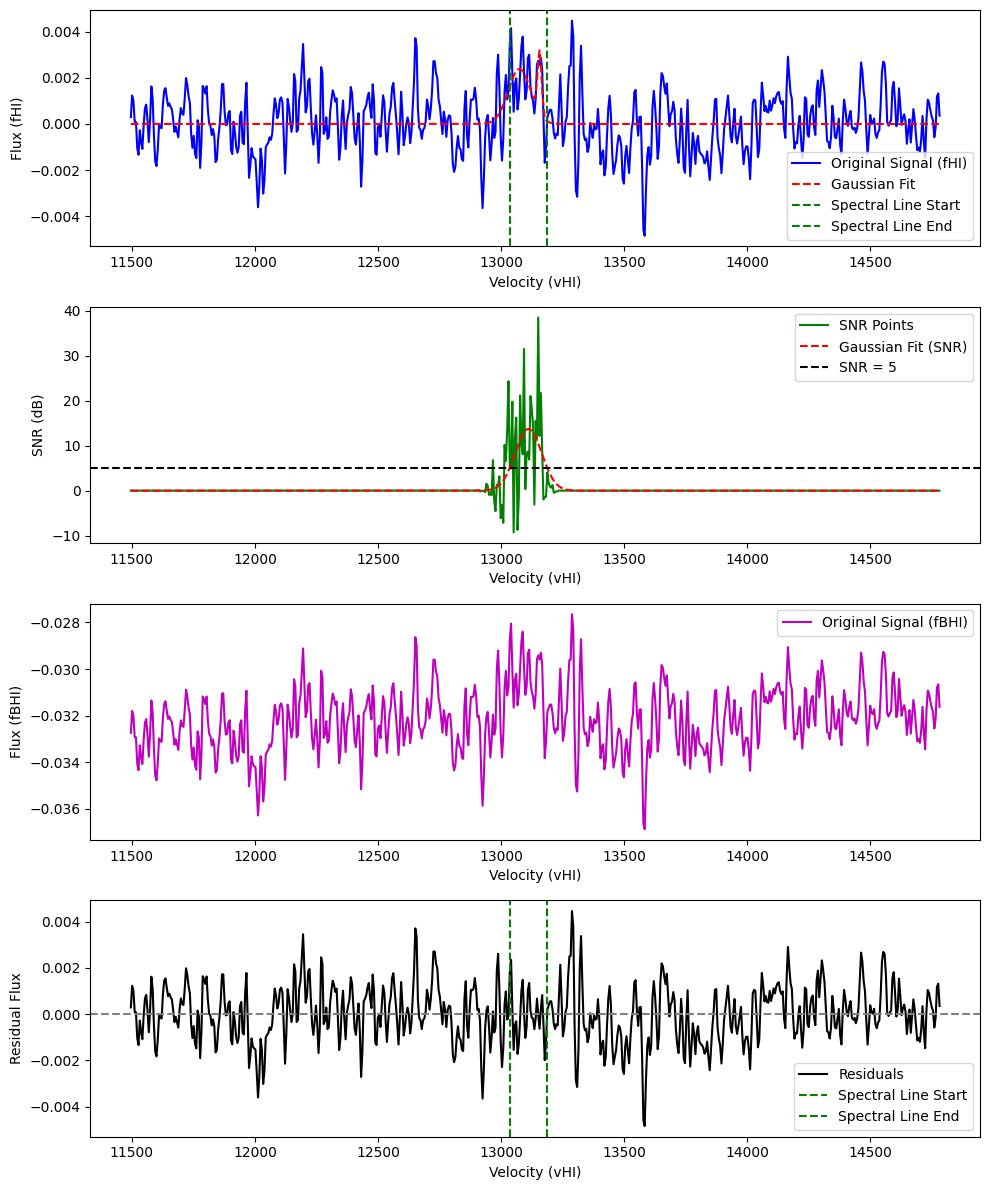

In [4]:
# Load data
file = 'mangaHI-8077-12705.csv'
timeSeries = pd.read_csv(file, names=['vHI', 'fHI', 'fBHI'])

time = timeSeries[22:-1].copy()
time[['vHI', 'fHI', 'fBHI']] = time['vHI'].str.split(expand=True)
time = time.reset_index(drop=True).astype(float)

x = time['vHI'].values
y = time['fHI'].values       # Used for Gaussian fitting (original fHI)
y_original = time['fBHI'].values  # Original signal from fBHI (for plotting)

# Clip signal by omitting the first and last 17% of the points
n_points = len(x)
clip_fraction = 0.17
start_index = int(n_points * clip_fraction)
end_index = int(n_points * (1 - clip_fraction)) - 1

x_trimmed = x[start_index:end_index+1]
y_trimmed = y[start_index:end_index+1]
y_original_trimmed = y_original[start_index:end_index+1]

# Perform normality test on the trimmed fHI signal
stat, p_value = normaltest(y_trimmed)

# Fit a single Gaussian first
g_init = models.Gaussian1D(amplitude=max(y_trimmed), mean=np.median(x_trimmed), stddev=10)
fitter = fitting.LevMarLSQFitter()
g_fit = fitter(g_init, x_trimmed, y_trimmed)

# If the normality test fails, attempt a double Gaussian fit
if p_value < 0.05:
    print("Data can't be described by a single Gaussian fit -> using a double Gaussian fit")
    g_init = models.Gaussian1D(amplitude=max(y_trimmed), mean=np.median(x_trimmed), stddev=10) + \
             models.Gaussian1D(amplitude=max(y_trimmed), mean=np.median(x_trimmed) + 10, stddev=10)
    g_fit = fitter(g_init, x_trimmed, y_trimmed)

# Compute residuals (fHI - Gaussian fit)
residuals = y_trimmed - g_fit(x_trimmed)

#Implement SNR logic for region specification
snr_points = 20 * np.log10(np.abs(y_trimmed / residuals))
avg_snr = np.mean(snr_points)
SNR_g_init = models.Gaussian1D(amplitude=max(snr_points), mean=np.mean(x_trimmed), stddev=10)
SNR_g_fit = fitter(SNR_g_init, x_trimmed, snr_points)

# Identify spectral line region based on nonzero values of the Gaussian fit
#line_indices = np.where(g_fit(x_trimmed) > 0.0001)[0]  # indices where the fit is practically nonzero

line_indices = np.where(SNR_g_fit(x_trimmed) > 5)[0]  # indices where the fit is practically nonzero

if len(line_indices) > 0:
    # Define regions:
    before_line = np.arange(0, line_indices[0])
    spectral_line = line_indices
    after_line = np.arange(line_indices[-1] + 1, len(x_trimmed))

    # --- MSE and RMSE Calculations ---
    fit_values = g_fit(x_trimmed)
    
    # Region 1: Before spectral line
    if len(before_line) > 0:
        mse_region1 = mean_squared_error(y_trimmed[before_line], fit_values[before_line])
        rmse_region1 = np.sqrt(mse_region1)
    else:
        mse_region1 = np.nan
        rmse_region1 = np.nan

    # Region 2: Spectral line region
    if len(spectral_line) > 0:
        mse_region2 = mean_squared_error(y_trimmed[spectral_line], fit_values[spectral_line])
        rmse_region2 = np.sqrt(mse_region2)
    else:
        mse_region2 = np.nan
        rmse_region2 = np.nan

    # Region 3: After spectral line
    if len(after_line) > 0:
        mse_region3 = mean_squared_error(y_trimmed[after_line], fit_values[after_line])
        rmse_region3 = np.sqrt(mse_region3)
    else:
        mse_region3 = np.nan
        rmse_region3 = np.nan

    # Percentage differences
    pct_diff_mse_1_2 = (abs(mse_region2 - mse_region1) / mse_region1) * 100 if mse_region1 and mse_region1 != 0 else np.nan
    pct_diff_mse_1_3 = (abs(mse_region3 - mse_region1) / mse_region1) * 100 if mse_region1 and mse_region1 != 0 else np.nan
    pct_diff_rmse_1_2 = (abs(rmse_region2 - rmse_region1) / rmse_region1) * 100 if rmse_region1 and rmse_region1 != 0 else np.nan
    pct_diff_rmse_1_3 = (abs(rmse_region3 - rmse_region1) / rmse_region1) * 100 if rmse_region1 and rmse_region1 != 0 else np.nan

    # --- Noise Statistics on the Residuals ---
    mean_line = np.mean(residuals[spectral_line]) if len(spectral_line) > 0 else np.nan
    std_line = np.std(residuals[spectral_line]) if len(spectral_line) > 0 else np.nan
    mean_non_line = np.mean(residuals[before_line]) if len(before_line) > 0 else np.nan
    std_non_line = np.std(residuals[before_line]) if len(before_line) > 0 else np.nan

    std_diff_percentage = ((std_line - std_non_line) / std_non_line) * 100 if std_non_line > 0 else np.nan
    mean_diff_percentage = ((mean_line - mean_non_line) / abs(mean_non_line)) * 100 if mean_non_line != 0 else np.nan
    
    # --- SNR calculations ---
    # 1. Spectral line region SNR using mean value of signal and noise
    signal_power = np.mean(y_trimmed[spectral_line])  # Mean value of signal
    noise_power = np.mean(residuals) # Mean value of residuals (noise)
    snr_residuals = 10 * np.log10(signal_power / noise_power) if noise_power > 0 else np.nan

    # 2. Spectral line region SNR using average of SNR calculated at each point
    avg_snr = np.mean(snr_points)

    # --- Print Results ---
    print("\n--- Spectral line region SNR Calculations ---")
    print(f"SNR (Mean Signal value / Mean Noise value) : {snr_residuals:.2f} dB")
    print(f"SNR (Average of SNR calculated at each point): {avg_snr:.2f} dB")

    # Present metrics in formatted tables
    try:
        table_noise = [
            ["Spectral Line Region (Residuals) Mean", f"{mean_line:.6f}"],
            ["Spectral Line Region (Residuals) Std Dev", f"{std_line:.6f}"],
            ["Non-Spectral Line Region (Residuals) Mean", f"{mean_non_line:.6f}"],
            ["Non-Spectral Line Region (Residuals) Std Dev", f"{std_non_line:.6f}"],
            ["% Diff in Mean (Residuals)", f"{mean_diff_percentage:.2f}%"],
            ["% Diff in Std Dev (Residuals)", f"{std_diff_percentage:.2f}%"],
        ]
        table_mse_rmse = [
            ["MSE (Region 1, Before)", f"{mse_region1:.8f}"],
            ["MSE (Region 2, Spectral)", f"{mse_region2:.8f}"],
            ["MSE (Region 3, After)", f"{mse_region3:.8f}"],
            ["RMSE (Region 1, Before)", f"{rmse_region1:.8f}"],
            ["RMSE (Region 2, Spectral)", f"{rmse_region2:.8f}"],
            ["RMSE (Region 3, After)", f"{rmse_region3:.8f}"],
            ["% Diff in MSE (R1 vs R2)", f"{pct_diff_mse_1_2:.2f}%"],
            ["% Diff in MSE (R1 vs R3)", f"{pct_diff_mse_1_3:.2f}%"],
            ["% Diff in RMSE (R1 vs R2)", f"{pct_diff_rmse_1_2:.2f}%"],
            ["% Diff in RMSE (R1 vs R3)", f"{pct_diff_rmse_1_3:.2f}%"],
        ]
        print("\n--- Noise Statistics (Residuals) ---")
        print(tabulate(table_noise, headers=["Metric", "Value"], tablefmt="pretty", showindex=False))
        print("\n--- MSE and RMSE Comparisons ---")
        print(tabulate(table_mse_rmse, headers=["Metric", "Value"], tablefmt="pretty", showindex=False))
    except ImportError:
        print("--- Noise Statistics (Residuals) ---")
        print(f"Spectral Line Region -> Mean: {mean_line:.6f}, Std Dev: {std_line:.6f}")
        print(f"Non-Spectral Line Region -> Mean: {mean_non_line:.6f}, Std Dev: {std_non_line:.6f}")
        print(f"% Diff in Mean: {mean_diff_percentage:.2f}%")
        print(f"% Diff in Std Dev: {std_diff_percentage:.2f}%")
        print("------------------------------------")
        print("--- MSE and RMSE Comparisons ---")
        print(f"MSE (Region 1, Before): {mse_region1:.8f}")
        print(f"MSE (Region 2, Spectral): {mse_region2:.8f}")
        print(f"MSE (Region 3, After): {mse_region3:.8f}")
        print(f"RMSE (Region 1, Before): {rmse_region1:.8f}")
        print(f"RMSE (Region 2, Spectral): {rmse_region2:.8f}")
        print(f"RMSE (Region 3, After): {rmse_region3:.8f}")
        print(f"% Diff in MSE (R1 vs R2): {pct_diff_mse_1_2:.2f}%")
        print(f"% Diff in MSE (R1 vs R3): {pct_diff_mse_1_3:.2f}%")
        print(f"% Diff in RMSE (R1 vs R2): {pct_diff_rmse_1_2:.2f}%")
        print(f"% Diff in RMSE (R1 vs R3): {pct_diff_rmse_1_3:.2f}%")

# Plot results
plt.figure(figsize=(10, 12))

# Plot 1: fHI signal and Gaussian fit
plt.subplot(4, 1, 1)
plt.plot(x_trimmed, y_trimmed, 'b-', label='Original Signal (fHI)')
plt.plot(x_trimmed, g_fit(x_trimmed), 'r--', label='Gaussian Fit')
if len(line_indices) > 0:
    plt.axvline(x_trimmed[line_indices[0]], color='g', linestyle='--', label="Spectral Line Start")
    plt.axvline(x_trimmed[line_indices[-1]], color='g', linestyle='--', label="Spectral Line End")
plt.xlabel("Velocity (vHI)")
plt.ylabel("Flux (fHI)")
plt.legend()

# Plot 2: SNR points and Gaussian fit
plt.subplot(4, 1, 2)
plt.plot(x_trimmed, snr_points, 'g-', label='SNR Points')
plt.plot(x_trimmed, SNR_g_fit(x_trimmed), 'r--', label='Gaussian Fit (SNR)')
plt.axhline(y = 5, color = 'k', linestyle = '--', label='SNR = 5')
plt.xlabel("Velocity (vHI)")
plt.ylabel("SNR (dB)")
plt.legend()

# Plot 3: Original fBHI signal
plt.subplot(4, 1, 3)
plt.plot(x_trimmed, y_original_trimmed, 'm-', label='Original Signal (fBHI)')
plt.xlabel("Velocity (vHI)")
plt.ylabel("Flux (fBHI)")
plt.legend()

# Plot 4: Residuals (fHI - Gaussian fit)
plt.subplot(4, 1, 4)
plt.plot(x_trimmed, residuals, '-k', label='Residuals')
plt.axhline(0, color='gray', linestyle='--')
if len(line_indices) > 0:
    plt.axvline(x_trimmed[line_indices[0]], color='g', linestyle='--', label="Spectral Line Start")
    plt.axvline(x_trimmed[line_indices[-1]], color='g', linestyle='--', label="Spectral Line End")
plt.xlabel("Velocity (vHI)")
plt.ylabel("Residual Flux")
plt.legend()

plt.tight_layout()
plt.show()


#### SNR experimentation

0.0015715283356796115
7.687183596504418e-05
2.877642240131062


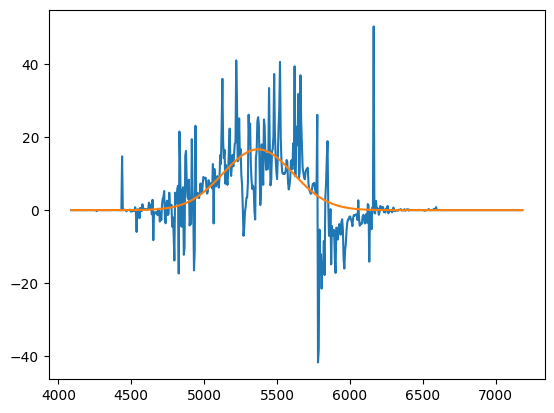

In [ ]:
#SNR experimentation
# 1. Spectral line region SNR using mean value of signal and noise
signal_power = np.mean(y_trimmed)  # Mean value of signal
noise_power = np.mean(residuals) # Mean value of residuals (noise)
snr_residuals = 20 * np.log10(signal_power / noise_power) if noise_power > 0 else np.nan
print(signal_power)
print(noise_power)

# 2. Spectral line region SNR using average of SNR calculated at each point
snr_points = 20 * np.log10(np.abs(y_trimmed / residuals))
avg_snr = np.mean(snr_points)
print(avg_snr)
g_init = models.Gaussian1D(amplitude=max(snr_points), mean=np.median(x_trimmed), stddev=10)
g_fit = fitter(g_init, x_trimmed, snr_points)

plt.plot(x_trimmed, snr_points)
plt.plot(x_trimmed, g_fit(x_trimmed))

### Fit 1, 2, 3 gaussian fits and compare metrics to find best fit


--- Gaussian Fit Comparisons ---

Gaussian 1:
  % Diff in MSE (R1 vs R2): 142.04%
  % Diff in RMSE (R1 vs R2): 55.57%
  % Diff in Mean (Residuals): 604.84%
  % Diff in Std Dev (Residuals): 51.77%
  AIC Score: -7839.39

Gaussian 2:
  % Diff in MSE (R1 vs R2): 115.75%
  % Diff in RMSE (R1 vs R2): 46.89%
  % Diff in Mean (Residuals): 617.25%
  % Diff in Std Dev (Residuals): 45.48%
  AIC Score: -7912.82

Best fit: 2 Gaussian(s) (Lowest AIC = -7912.82)


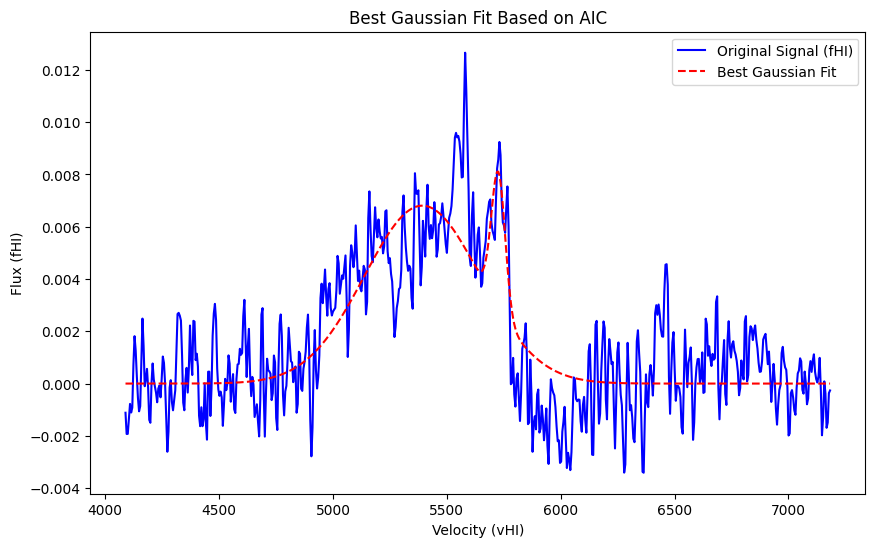

In [ ]:
# Load data
file = 'mangaHI-7443-1902.csv'
timeSeries = pd.read_csv(file, names=['vHI', 'fHI', 'fBHI'])

time = timeSeries[22:-1].copy()
time[['vHI', 'fHI', 'fBHI']] = time['vHI'].str.split(expand=True)
time = time.reset_index(drop=True).astype(float)

x = time['vHI'].values
y = time['fHI'].values       # Used for Gaussian fitting (original fHI)
y_original = time['fBHI'].values  # Original signal from fBHI (for plotting)

# Clip signal by omitting the first and last 17% of the points
n_points = len(x)
clip_fraction = 0.17
start_index = int(n_points * clip_fraction)
end_index = int(n_points * (1 - clip_fraction)) - 1

x_trimmed = x[start_index:end_index+1]
y_trimmed = y[start_index:end_index+1]
y_original_trimmed = y_original[start_index:end_index+1]

# Function to fit Gaussian models
def fit_gaussians(num_gaussians):
    fitter = fitting.LevMarLSQFitter()
    
    # Initialize the first Gaussian
    g_init = models.Gaussian1D(amplitude=max(y_trimmed), mean=np.mean(x_trimmed), stddev=10)
    
    # Add additional Gaussians if necessary
    for i in range(1, num_gaussians):
        g_init += models.Gaussian1D(amplitude=max(y_trimmed) / (i + 1), mean=np.mean(x_trimmed) + i * 10, stddev=10)
    
    g_fit = fitter(g_init, x_trimmed, y_trimmed)
    return g_fit

# Fit 1, 2, and 3 gaussian fits
fits = {n: fit_gaussians(n) for n in [1, 2, 3]}

# Compute fit metrics
def compute_metrics(g_fit):
    residuals = y_trimmed - g_fit(x_trimmed)
    snr_points = 20 * np.log10(np.abs(y_trimmed / residuals))

    # Define the spectral line region
    SNR_g_init = models.Gaussian1D(amplitude=max(snr_points), mean=np.mean(x_trimmed), stddev=10)
    SNR_g_fit = fitting.LevMarLSQFitter()(SNR_g_init, x_trimmed, snr_points)
    line_indices = np.where(SNR_g_fit(x_trimmed) > 5)[0]

    if len(line_indices) > 0:
        before_line = np.arange(0, line_indices[0])
        spectral_line = line_indices

        mse_region1 = mean_squared_error(y_trimmed[before_line], g_fit(x_trimmed)[before_line]) if len(before_line) > 0 else np.nan
        mse_region2 = mean_squared_error(y_trimmed[spectral_line], g_fit(x_trimmed)[spectral_line]) if len(spectral_line) > 0 else np.nan

        rmse_region1 = np.sqrt(mse_region1) if not np.isnan(mse_region1) else np.nan
        rmse_region2 = np.sqrt(mse_region2) if not np.isnan(mse_region2) else np.nan

        pct_diff_mse = (abs(mse_region2 - mse_region1) / mse_region1) * 100 if mse_region1 and mse_region1 != 0 else np.nan
        pct_diff_rmse = (abs(rmse_region2 - rmse_region1) / rmse_region1) * 100 if rmse_region1 and rmse_region1 != 0 else np.nan

        mean_line = np.mean(residuals[spectral_line]) if len(spectral_line) > 0 else np.nan
        std_line = np.std(residuals[spectral_line]) if len(spectral_line) > 0 else np.nan
        mean_non_line = np.mean(residuals[before_line]) if len(before_line) > 0 else np.nan
        std_non_line = np.std(residuals[before_line]) if len(before_line) > 0 else np.nan

        mean_diff_percentage = ((mean_line - mean_non_line) / abs(mean_non_line)) * 100 if mean_non_line != 0 else np.nan
        std_diff_percentage = ((std_line - std_non_line) / std_non_line) * 100 if std_non_line > 0 else np.nan

        return {
            "g_fit": g_fit,
            "residuals": residuals,
            "mse": pct_diff_mse,
            "rmse": pct_diff_rmse,
            "mean_diff": mean_diff_percentage,
            "std_diff": std_diff_percentage
        }
    return None

# Compute AIC
def compute_aic(g_fit):
    residuals = y_trimmed - g_fit(x_trimmed)
    ssr = np.sum(residuals**2)  # Sum of squared residuals
    n_params = len(g_fit.parameters)  # Number of parameters in the model
    n_samples = len(y_trimmed)  # Number of data points

    return akaike_info_criterion_lsq(ssr, n_params, n_samples)

# Compute metrics and AIC values for all fits
metrics = {n: compute_metrics(fits[n]) for n in fits if compute_metrics(fits[n]) is not None}
aic_values = {n: compute_aic(fits[n]) for n in fits if fits[n] is not None}

if metrics and aic_values:
    # Select the best fit using the lowest AIC value
    best_fit_n = min(aic_values.items(), key=lambda x: x[1])[0]
    best_fit = fits[best_fit_n]

    # Print comparison results
    print("\n--- Gaussian Fit Comparisons ---")
    for n, result in metrics.items():
        print(f"\nGaussian {n}:")
        print(f"  % Diff in MSE (R1 vs R2): {result['mse']:.2f}%")
        print(f"  % Diff in RMSE (R1 vs R2): {result['rmse']:.2f}%")
        print(f"  % Diff in Mean (Residuals): {result['mean_diff']:.2f}%")
        print(f"  % Diff in Std Dev (Residuals): {result['std_diff']:.2f}%")
        print(f"  AIC Score: {aic_values[n]:.2f}")

    print(f"\nBest fit: {best_fit_n} Gaussian(s) (Lowest AIC = {aic_values[best_fit_n]:.2f})")

    # Plot the best fit
    plt.figure(figsize=(10, 6))
    plt.plot(x_trimmed, y_trimmed, 'b-', label='Original Signal (fHI)')
    plt.plot(x_trimmed, best_fit(x_trimmed), 'r--', label='Best Gaussian Fit')
    plt.xlabel("Velocity (vHI)")
    plt.ylabel("Flux (fHI)")
    plt.legend()
    plt.title("Best Gaussian Fit (based on AIC)")
    plt.show()
else:
    print("No spectral line regions found suitable for fitting.")

## Database access

### Connect to database and fetch a single signal

Selected src_file: mangaHI-8978-1901.csv
Fetched 1024 data points.


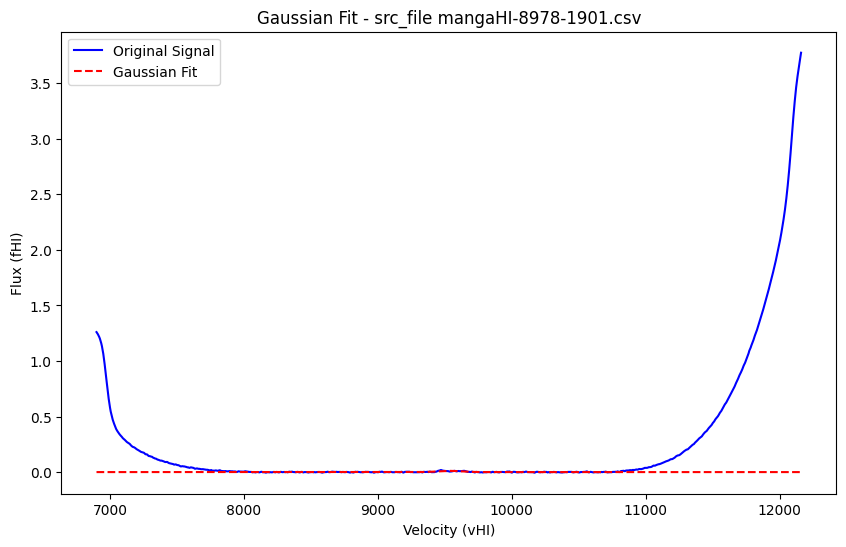

In [19]:
# Database connection details
db_config = {
    "host": "195.201.104.116",
    "user": "eta14802_astrobeam",
    "password": "PGdAR{F[1C#~",
    "database": "eta14802_astrobeam"
}

# Connect to the database
try:
    conn = mysql.connector.connect(**db_config)
    cursor = conn.cursor()

    # Find a src_file that has multiple points
    query = "SELECT src_file, COUNT(*) FROM gbt_data GROUP BY src_file ORDER BY COUNT(*) DESC LIMIT 1;"
    cursor.execute(query)
    src_file = cursor.fetchone()[0]
    print(f"Selected src_file: {src_file}")

    # Fetch all vHI and fHI values for that src_file
    query = f"SELECT vHI, fHI FROM gbt_data WHERE src_file = '{src_file}' ORDER BY vHI;"
    cursor.execute(query)
    data = pd.DataFrame(cursor.fetchall(), columns=["vHI", "fHI"])

    if data.empty:
        print("No data found for this src_file.")
    else:
        print(f"Fetched {len(data)} data points.")

    # Remove NaNs
    data = data.dropna()

    # Extract velocity and flux
    x = data["vHI"].values
    y = data["fHI"].values

    if len(x) < 3:
        print("Insufficient points for Gaussian fitting.")
    else:
        # Fit a Gaussian
        fitter = fitting.LevMarLSQFitter()
        g_init = models.Gaussian1D(amplitude=np.max(y), mean=np.median(x), stddev=10)
        g_fit = fitter(g_init, x, y)

        # Plot original signal and Gaussian fit
        plt.figure(figsize=(10, 6))
        plt.plot(x, y, 'b-', label='Original Signal')
        plt.plot(x, g_fit(x), 'r--', label='Gaussian Fit')
        plt.xlabel("Velocity (vHI)")
        plt.ylabel("Flux (fHI)")
        plt.legend()
        plt.title(f"Gaussian Fit - src_file {src_file}")
        plt.show()

except mysql.connector.Error as err:
    print("Error:", err)

finally:
    cursor.close()
    conn.close()

### Fetch 20 random signals from the database and perform gaussian fitting and error estimation

Selected src_file: mangaHI-8716-9101.csv
Selected 20 random signals.
Data from signal mangaHI-9193-1901.csv can't be described by a single Gaussian fit.
Results for signal mangaHI-9193-1901.csv:
  Spectral Line Region -> Mean: -0.000111, Std Dev: 0.000154
  Non-Spectral Line Region -> Mean: 0.000273, Std Dev: 0.001537
  Percentage Difference in Mean: -140.79%
  Percentage Difference in Std Dev: -89.98%
--------------------------------------------------


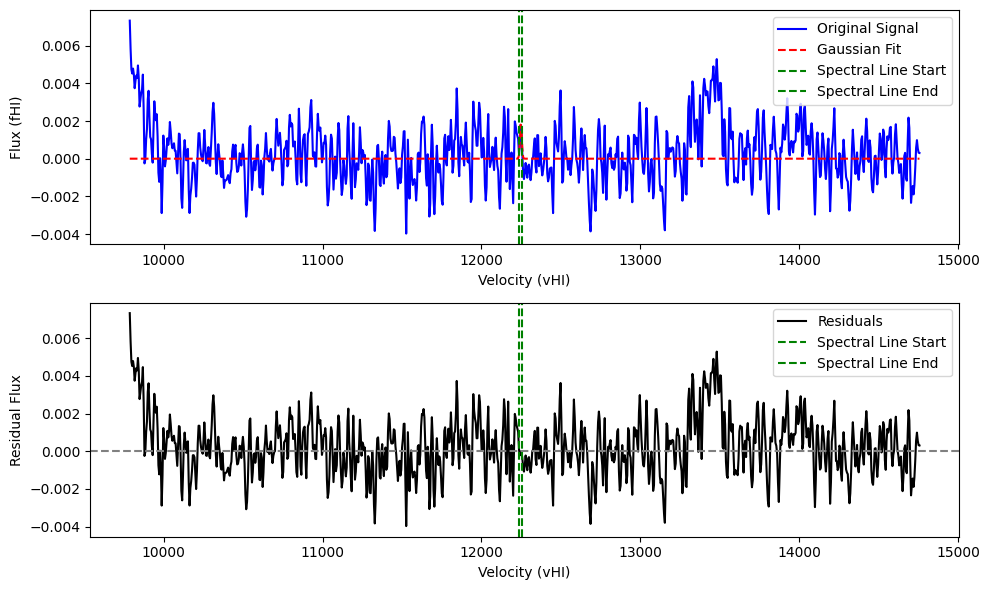

Data from signal mangaHI-8084-3703.csv can't be described by a single Gaussian fit.
Results for signal mangaHI-8084-3703.csv:
  Spectral Line Region -> Mean: 0.000001, Std Dev: 0.000000
  Non-Spectral Line Region -> Mean: 0.000129, Std Dev: 0.001524
  Percentage Difference in Mean: -99.01%
  Percentage Difference in Std Dev: -100.00%
--------------------------------------------------


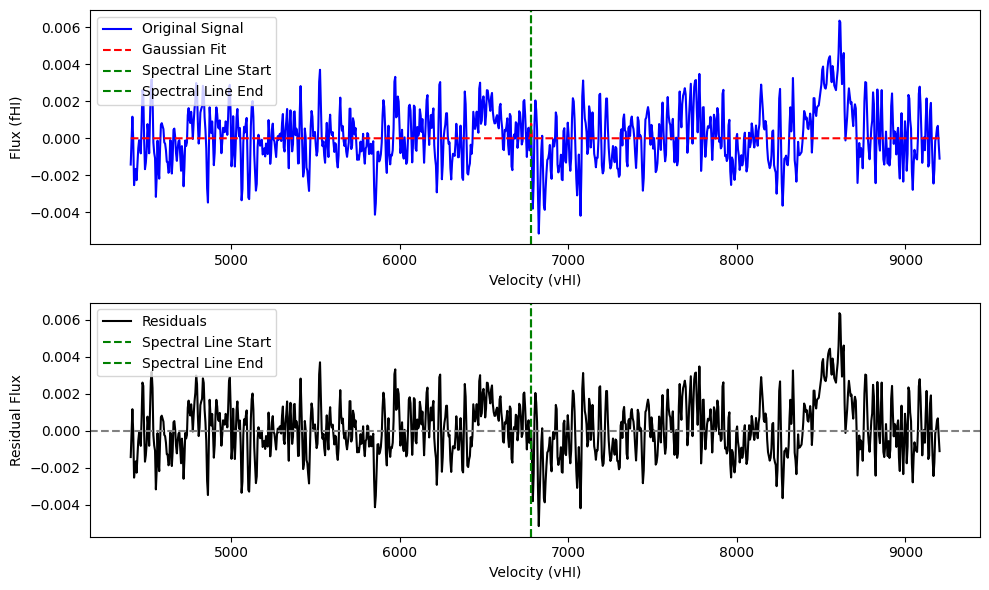

Data from signal mangaHI-11982-12705.csv can't be described by a single Gaussian fit.
Results for signal mangaHI-11982-12705.csv:
  Spectral Line Region -> Mean: 0.000013, Std Dev: 0.001255
  Non-Spectral Line Region -> Mean: -0.000393, Std Dev: 0.002398
  Percentage Difference in Mean: 103.24%
  Percentage Difference in Std Dev: -47.65%
--------------------------------------------------


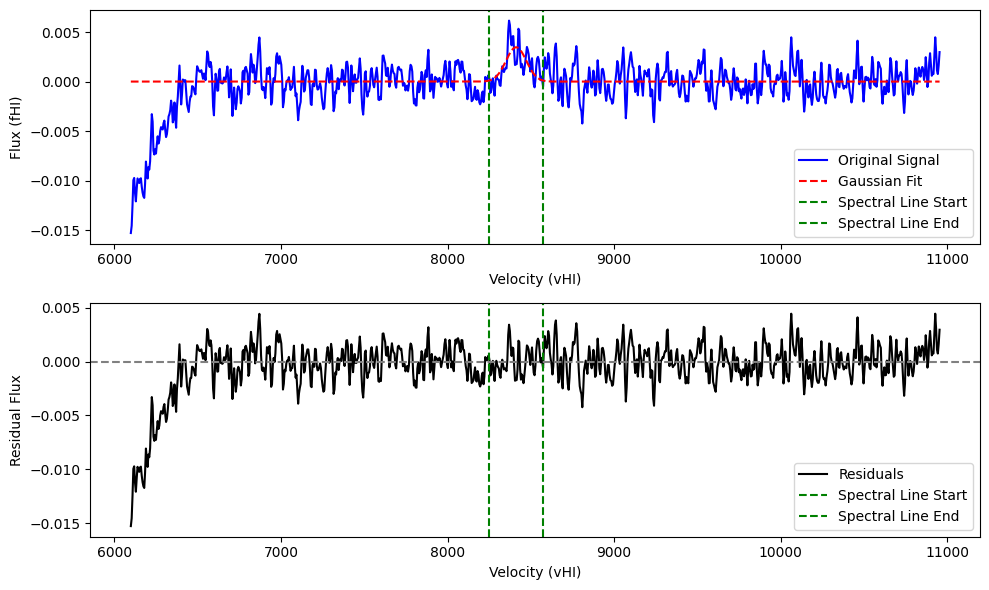

Results for signal mangaHI-8595-3704.csv:
  Spectral Line Region -> Mean: 0.000092, Std Dev: 0.001314
  Non-Spectral Line Region -> Mean: -0.000057, Std Dev: 0.001148
  Percentage Difference in Mean: 260.44%
  Percentage Difference in Std Dev: 14.48%
--------------------------------------------------


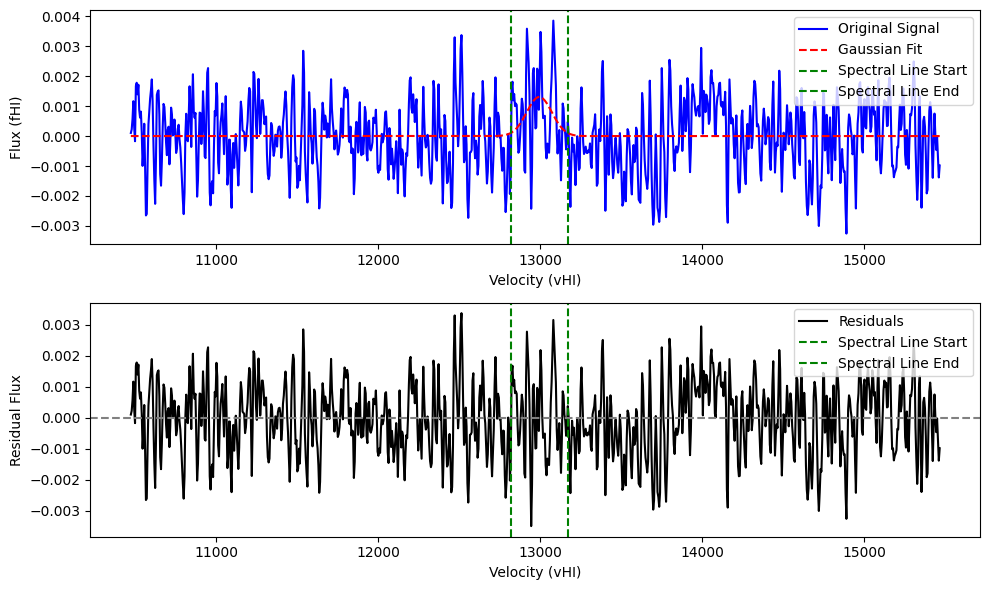

Data from signal mangaHI-8085-3704.csv can't be described by a single Gaussian fit.
Results for signal mangaHI-8085-3704.csv:
  Spectral Line Region -> Mean: 0.000128, Std Dev: 0.001213
  Non-Spectral Line Region -> Mean: 0.000035, Std Dev: 0.001263
  Percentage Difference in Mean: 268.08%
  Percentage Difference in Std Dev: -3.98%
--------------------------------------------------


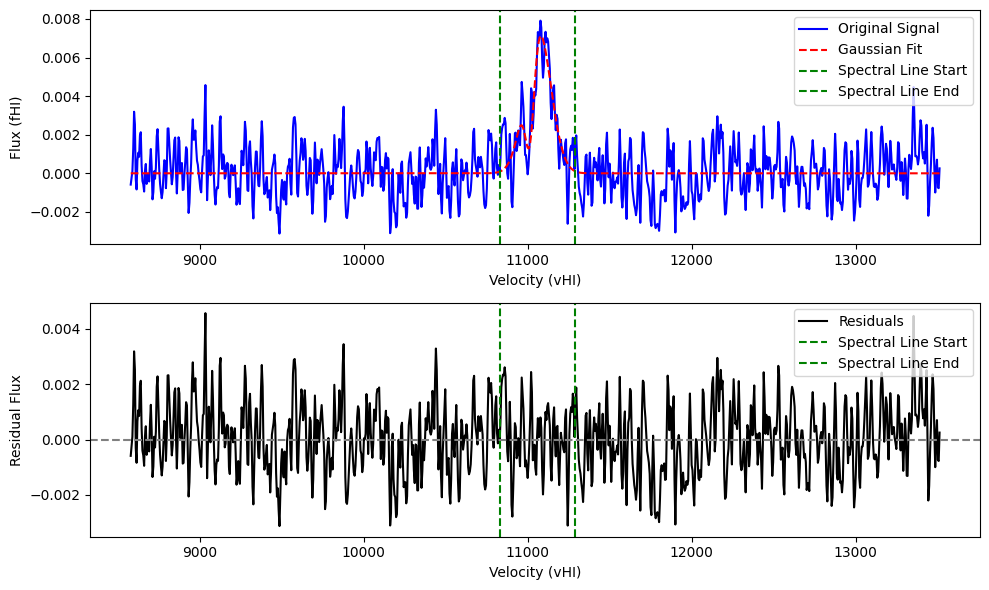

Data from signal mangaHI-8988-12705.csv can't be described by a single Gaussian fit.
Results for signal mangaHI-8988-12705.csv:
  Spectral Line Region -> Mean: -0.000338, Std Dev: 0.001481
  Non-Spectral Line Region -> Mean: -0.000465, Std Dev: 0.001712
  Percentage Difference in Mean: 27.23%
  Percentage Difference in Std Dev: -13.53%
--------------------------------------------------


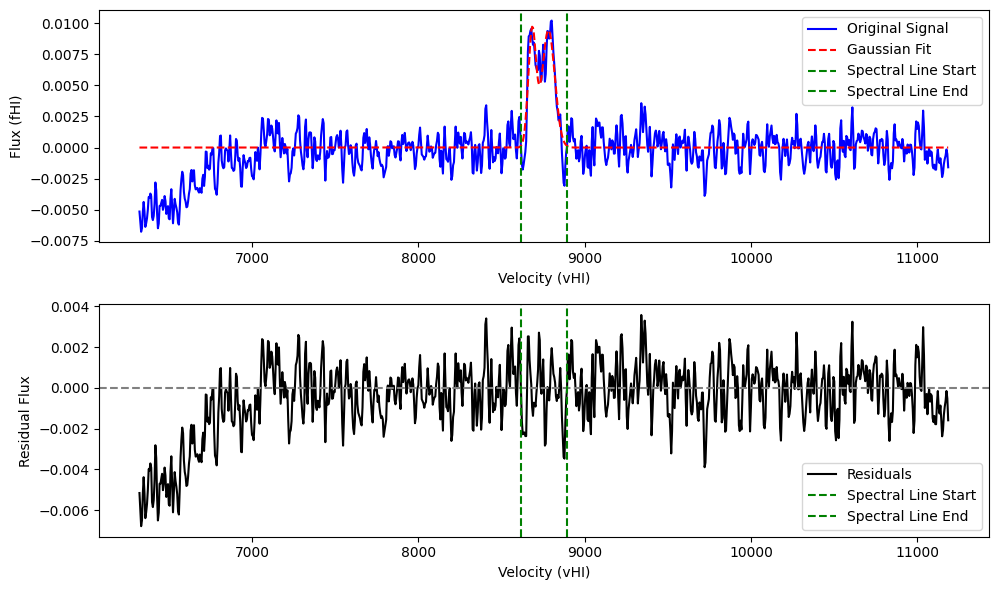

Results for signal mangaHI-7968-9101.csv:
  Spectral Line Region -> Mean: nan, Std Dev: nan
  Non-Spectral Line Region -> Mean: -0.000074, Std Dev: 0.001551
  Percentage Difference in Mean: nan%
  Percentage Difference in Std Dev: nan%
--------------------------------------------------


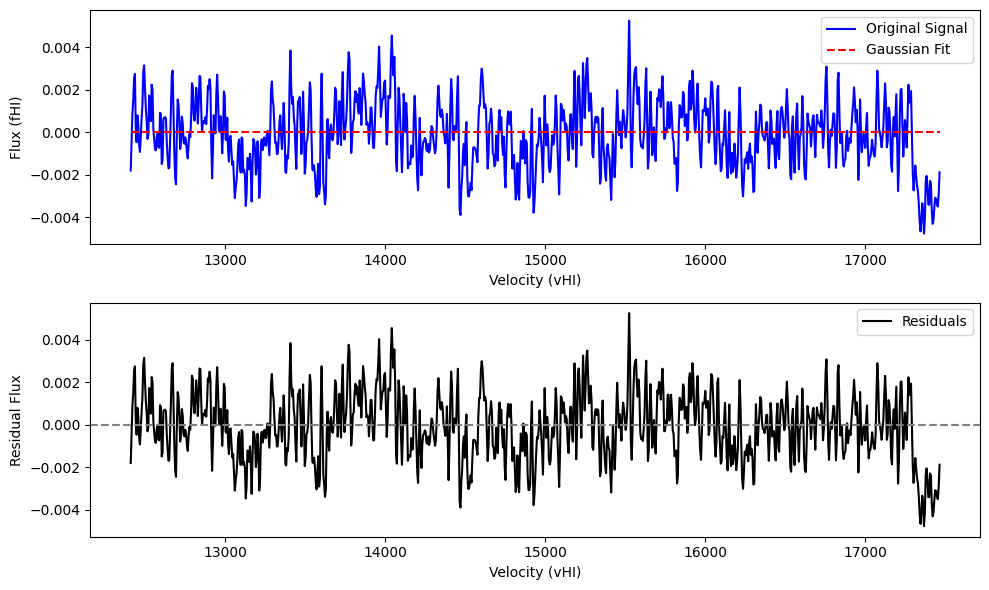

Data from signal mangaHI-10001-3704.csv can't be described by a single Gaussian fit.
Results for signal mangaHI-10001-3704.csv:
  Spectral Line Region -> Mean: 0.000028, Std Dev: 0.000060
  Non-Spectral Line Region -> Mean: -0.002337, Std Dev: 0.007623
  Percentage Difference in Mean: 101.19%
  Percentage Difference in Std Dev: -99.21%
--------------------------------------------------


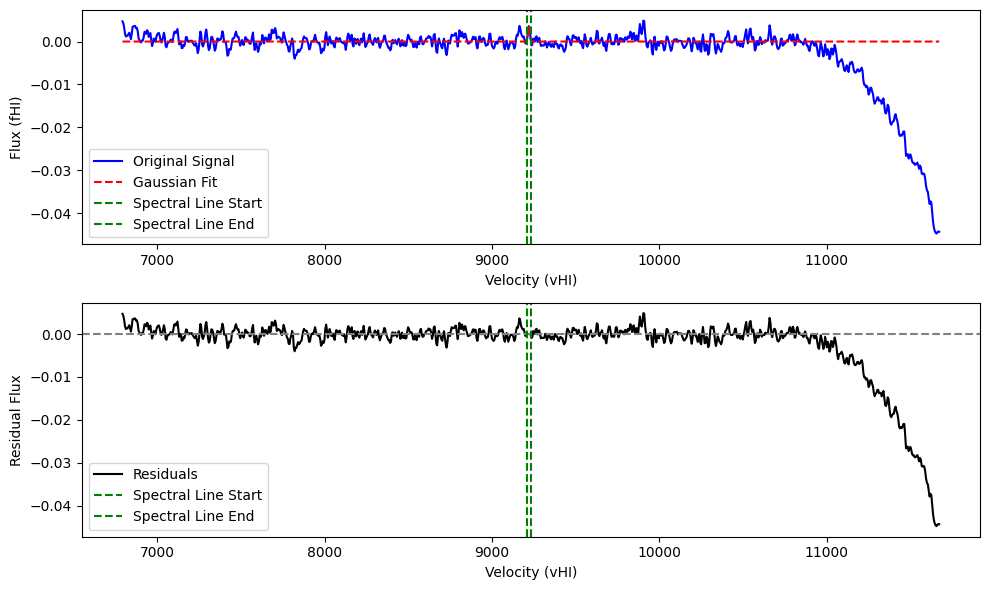

Data from signal mangaHI-10223-12702.csv can't be described by a single Gaussian fit.
Results for signal mangaHI-10223-12702.csv:
  Spectral Line Region -> Mean: -0.000113, Std Dev: 0.001030
  Non-Spectral Line Region -> Mean: -0.000613, Std Dev: 0.002860
  Percentage Difference in Mean: 81.57%
  Percentage Difference in Std Dev: -64.00%
--------------------------------------------------


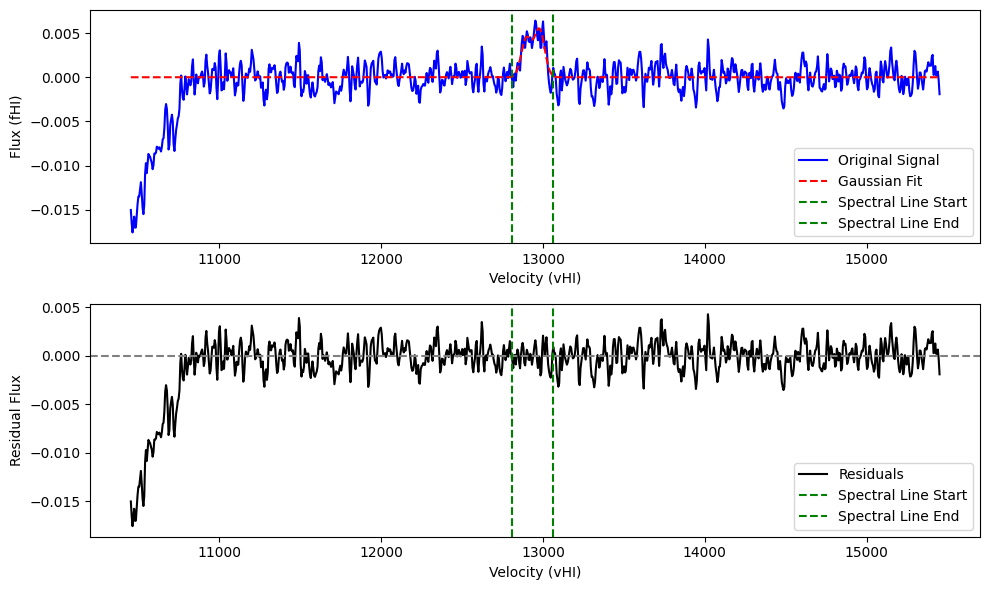

Data from signal mangaHI-9489-3703.csv can't be described by a single Gaussian fit.
Results for signal mangaHI-9489-3703.csv:
  Spectral Line Region -> Mean: -0.000322, Std Dev: 0.001251
  Non-Spectral Line Region -> Mean: 0.000042, Std Dev: 0.001389
  Percentage Difference in Mean: -859.31%
  Percentage Difference in Std Dev: -9.97%
--------------------------------------------------


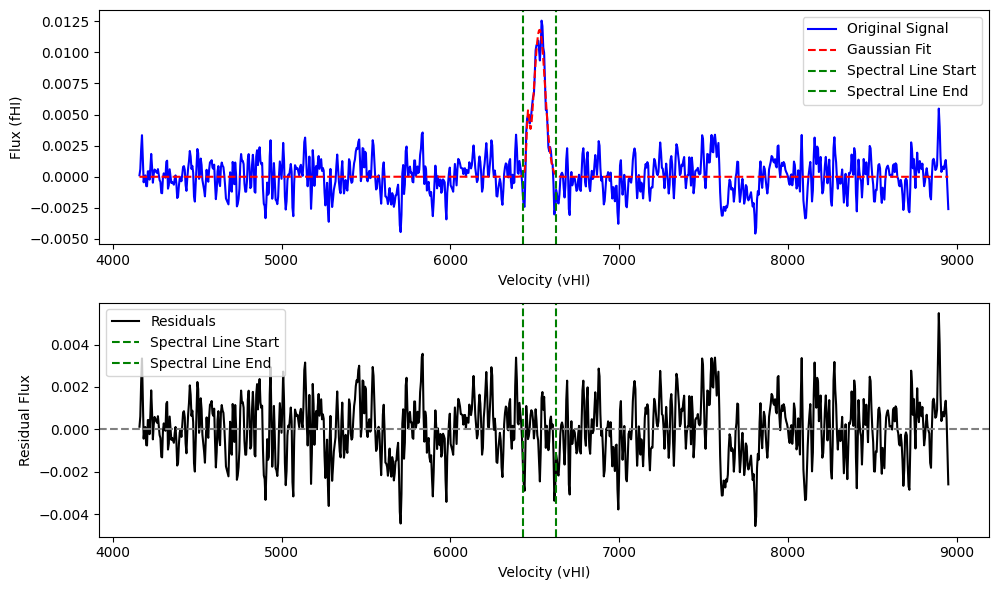

Data from signal mangaHI-8256-1902.csv can't be described by a single Gaussian fit.
Results for signal mangaHI-8256-1902.csv:
  Spectral Line Region -> Mean: -0.000018, Std Dev: 0.000913
  Non-Spectral Line Region -> Mean: -0.004535, Std Dev: 0.011635
  Percentage Difference in Mean: 99.61%
  Percentage Difference in Std Dev: -92.15%
--------------------------------------------------


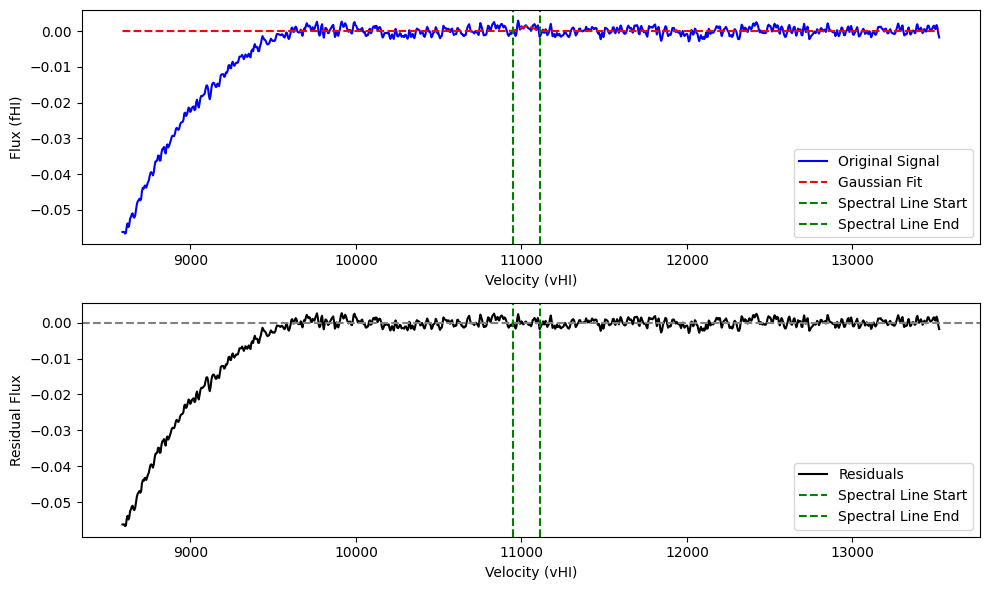

Data from signal mangaHI-8140-12702.csv can't be described by a single Gaussian fit.
Results for signal mangaHI-8140-12702.csv:
  Spectral Line Region -> Mean: 0.000083, Std Dev: 0.001104
  Non-Spectral Line Region -> Mean: -0.264289, Std Dev: 0.508381
  Percentage Difference in Mean: 100.03%
  Percentage Difference in Std Dev: -99.78%
--------------------------------------------------


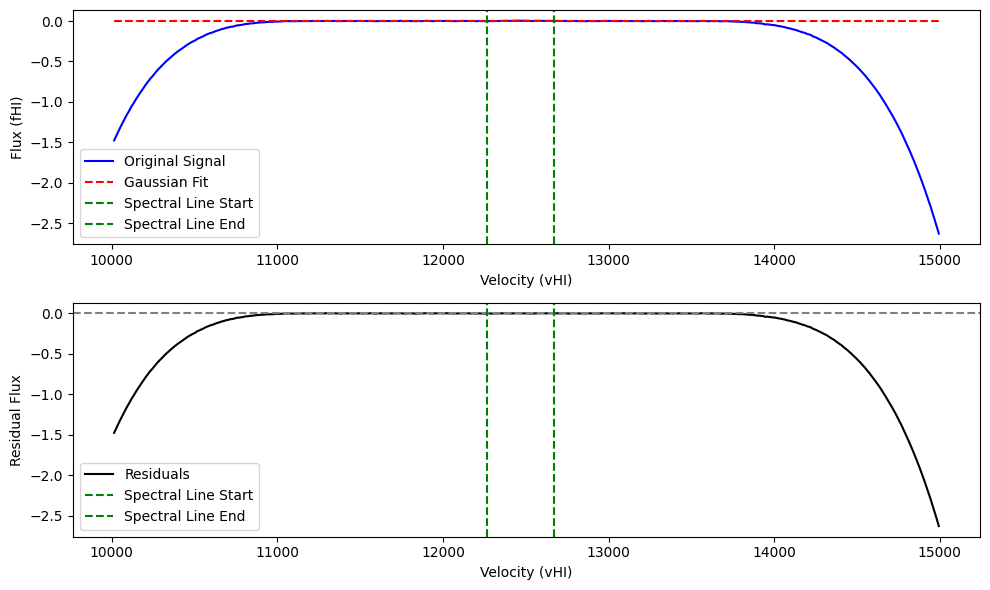

Data from signal mangaHI-8145-9101.csv can't be described by a single Gaussian fit.
Results for signal mangaHI-8145-9101.csv:
  Spectral Line Region -> Mean: -0.000050, Std Dev: 0.001754
  Non-Spectral Line Region -> Mean: -0.000078, Std Dev: 0.001610
  Percentage Difference in Mean: 35.96%
  Percentage Difference in Std Dev: 8.96%
--------------------------------------------------


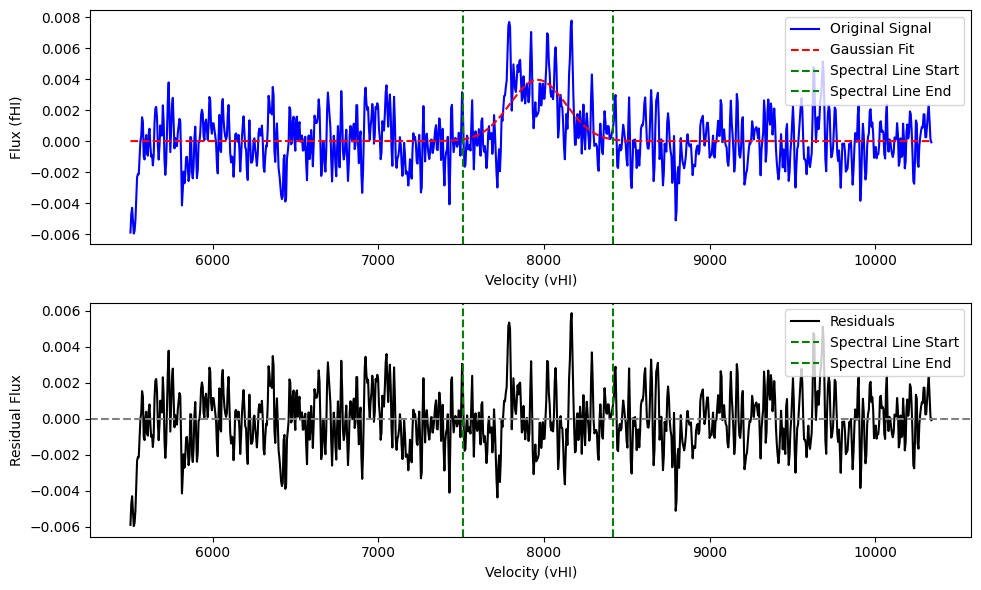

Data from signal mangaHI-8979-1902.csv can't be described by a single Gaussian fit.
Results for signal mangaHI-8979-1902.csv:
  Spectral Line Region -> Mean: -0.000041, Std Dev: 0.000795
  Non-Spectral Line Region -> Mean: -0.003897, Std Dev: 0.007207
  Percentage Difference in Mean: 98.95%
  Percentage Difference in Std Dev: -88.97%
--------------------------------------------------


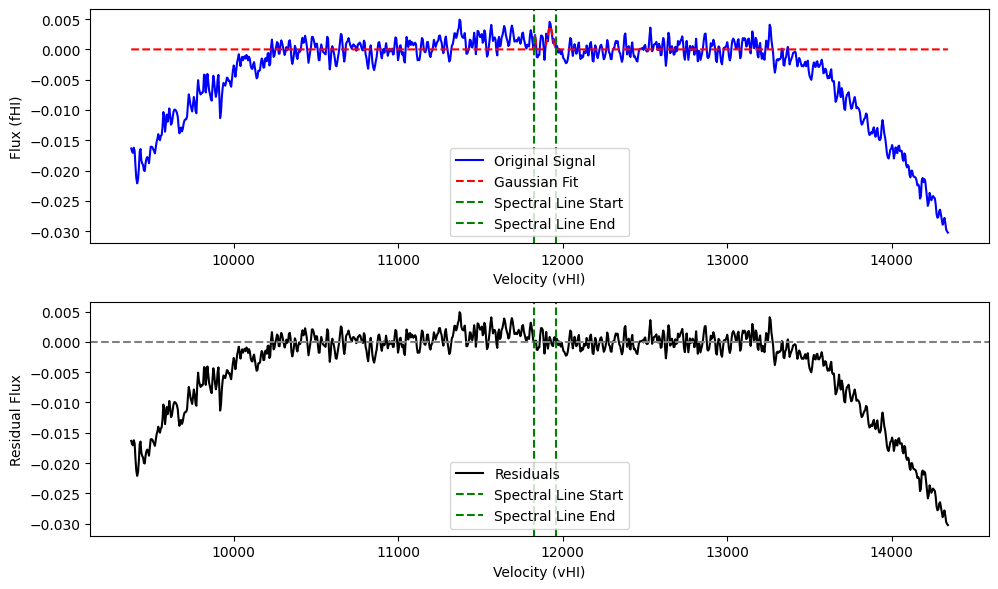

Data from signal mangaHI-7991-12701.csv can't be described by a single Gaussian fit.
Results for signal mangaHI-7991-12701.csv:
  Spectral Line Region -> Mean: -0.000162, Std Dev: 0.001528
  Non-Spectral Line Region -> Mean: 0.000107, Std Dev: 0.001591
  Percentage Difference in Mean: -252.46%
  Percentage Difference in Std Dev: -3.92%
--------------------------------------------------


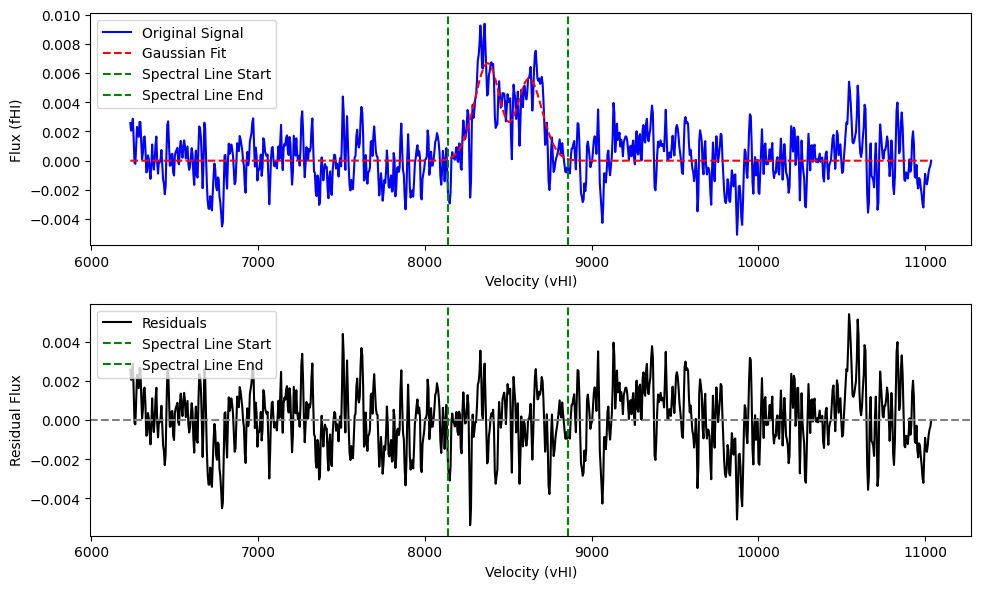

Data from signal mangaHI-9893-9102.csv can't be described by a single Gaussian fit.
Results for signal mangaHI-9893-9102.csv:
  Spectral Line Region -> Mean: -0.000127, Std Dev: 0.000249
  Non-Spectral Line Region -> Mean: 0.000077, Std Dev: 0.001721
  Percentage Difference in Mean: -264.38%
  Percentage Difference in Std Dev: -85.51%
--------------------------------------------------


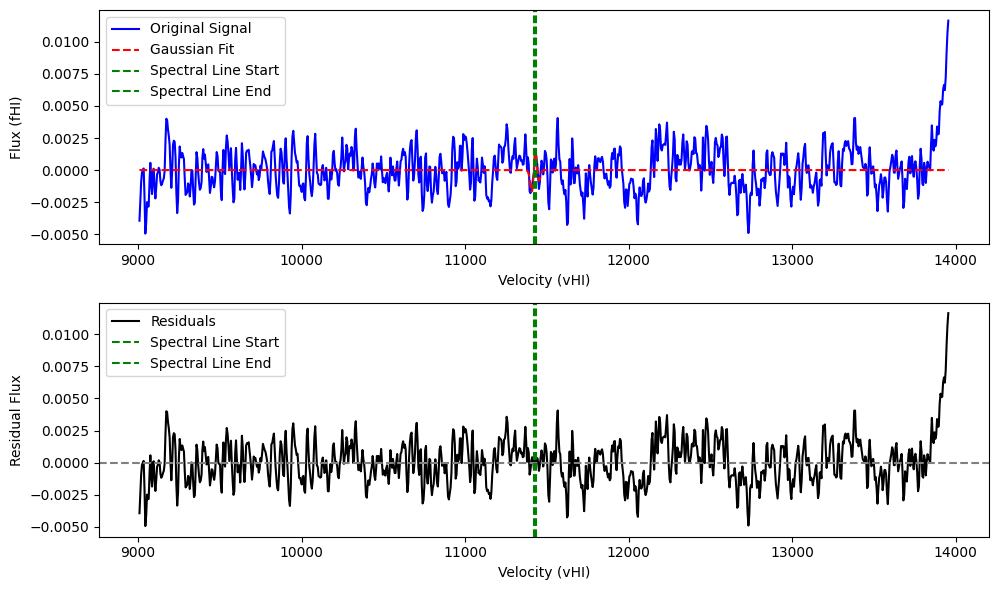

Data from signal mangaHI-9494-6103.csv can't be described by a single Gaussian fit.
Results for signal mangaHI-9494-6103.csv:
  Spectral Line Region -> Mean: -0.000060, Std Dev: 0.001189
  Non-Spectral Line Region -> Mean: 0.000082, Std Dev: 0.001186
  Percentage Difference in Mean: -172.46%
  Percentage Difference in Std Dev: 0.29%
--------------------------------------------------


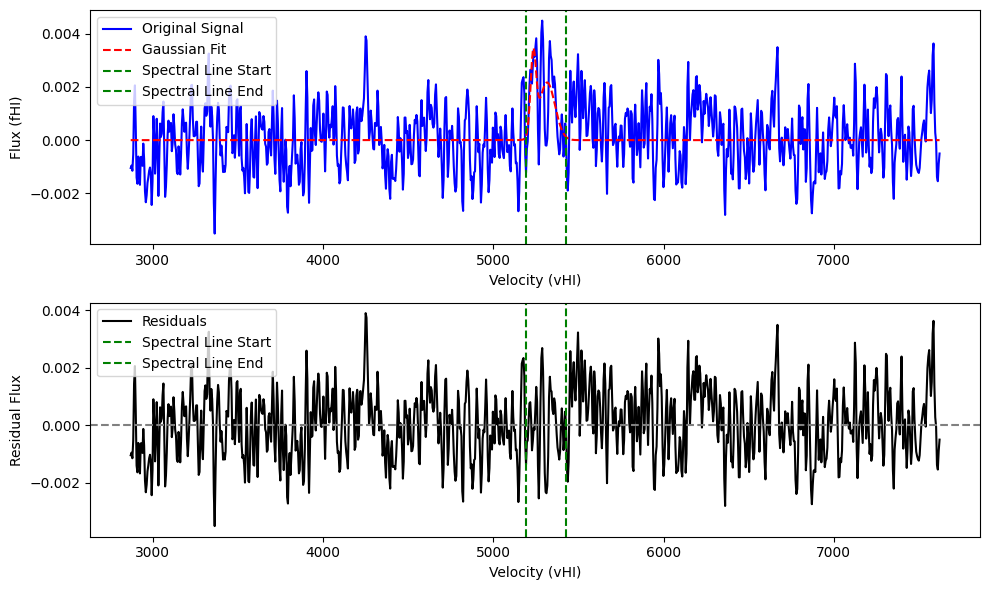

Data from signal mangaHI-8445-12701.csv can't be described by a single Gaussian fit.
Results for signal mangaHI-8445-12701.csv:
  Spectral Line Region -> Mean: -0.000341, Std Dev: 0.003359
  Non-Spectral Line Region -> Mean: 0.020679, Std Dev: 0.219428
  Percentage Difference in Mean: -101.65%
  Percentage Difference in Std Dev: -98.47%
--------------------------------------------------


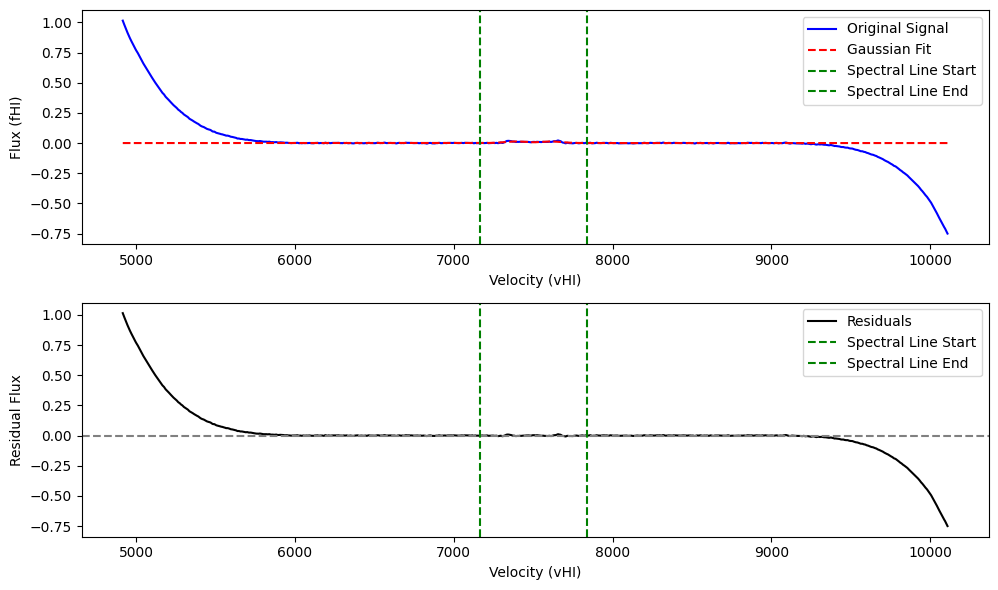

Data from signal mangaHI-8613-1901.csv can't be described by a single Gaussian fit.
Results for signal mangaHI-8613-1901.csv:
  Spectral Line Region -> Mean: 0.000027, Std Dev: 0.000038
  Non-Spectral Line Region -> Mean: 0.000738, Std Dev: 0.006104
  Percentage Difference in Mean: -96.31%
  Percentage Difference in Std Dev: -99.38%
--------------------------------------------------


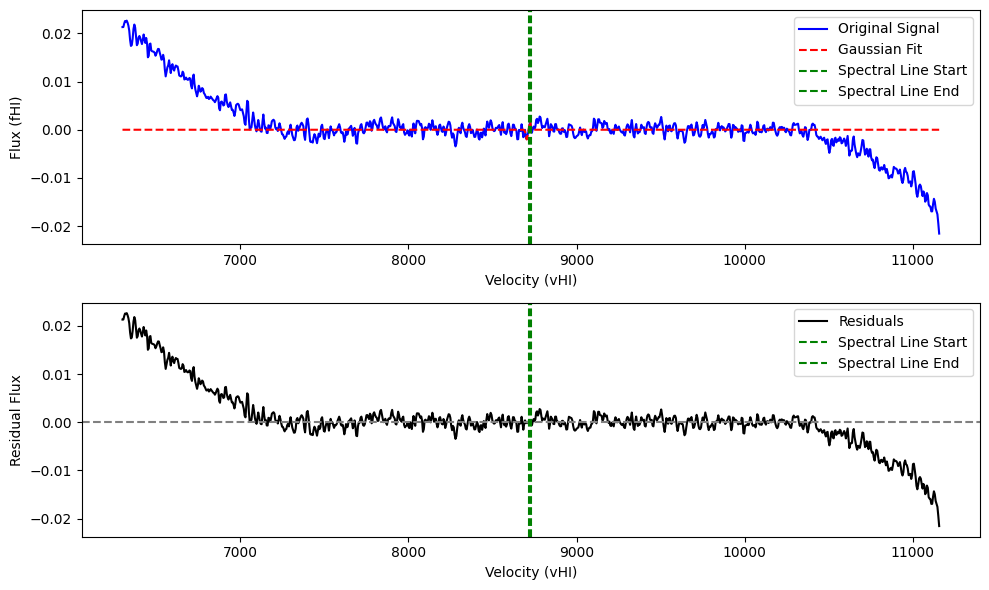

Data from signal mangaHI-8611-3702.csv can't be described by a single Gaussian fit.
Results for signal mangaHI-8611-3702.csv:
  Spectral Line Region -> Mean: -0.000069, Std Dev: 0.000710
  Non-Spectral Line Region -> Mean: 0.000031, Std Dev: 0.001320
  Percentage Difference in Mean: -322.93%
  Percentage Difference in Std Dev: -46.18%
--------------------------------------------------


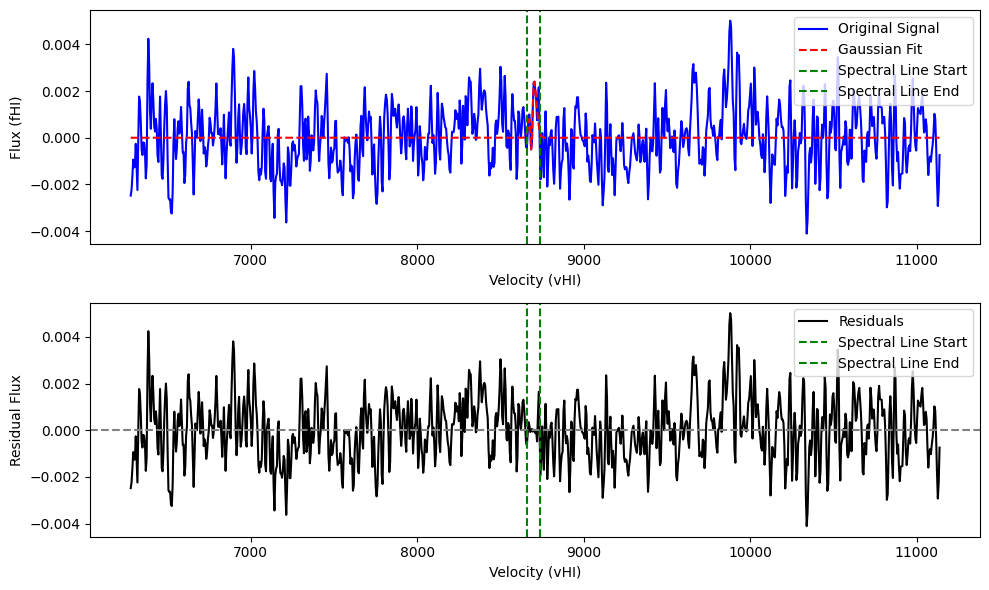

In [ ]:
# Database connection details
db_config = {
    "host": "195.201.104.116",
    "user": "eta14802_astrobeam",
    "password": "PGdAR{F[1C#~",
    "database": "eta14802_astrobeam"
}

# Connect to the database
try:
    conn = mysql.connector.connect(**db_config)
    cursor = conn.cursor()

    # Find a src_file that has multiple points
    query = "SELECT src_file, COUNT(*) FROM gbt_data GROUP BY src_file ORDER BY COUNT(*) DESC LIMIT 1;"
    cursor.execute(query)
    src_file = cursor.fetchone()[0]
    print(f"Selected src_file: {src_file}")

    # Fetch all src_file names for sampling 20 random signals
    query = "SELECT DISTINCT src_file FROM gbt_data;"
    cursor.execute(query)
    src_files = [row[0] for row in cursor.fetchall()]
    
    # Randomly select 20 signals
    random_signals = random.sample(src_files, 20)
    print(f"Selected {len(random_signals)} random signals.")

    for src_file in random_signals:
        # Fetch all vHI and fHI values for the signal
        query = f"SELECT vHI, fHI FROM gbt_data WHERE src_file = '{src_file}' ORDER BY vHI;"
        cursor.execute(query)
        data = pd.DataFrame(cursor.fetchall(), columns=["vHI", "fHI"])

        # Remove NaNs
        data = data.dropna()

        # Extract velocity and flux
        x = data["vHI"].values
        y = data["fHI"].values

        # Perform normality test to check if a single Gaussian is sufficient
        stat, p_value = normaltest(y)

        # Fit a single Gaussian first
        fitter = fitting.LevMarLSQFitter()
        g_init = models.Gaussian1D(amplitude=np.max(y), mean=np.median(x), stddev=10)
        g_fit = fitter(g_init, x, y)

        # If the normality test fails (low p-value), attempt a double Gaussian fit
        if p_value < 0.05:
            print(f"Data from signal {src_file} can't be described by a single Gaussian fit.")
            g_init = models.Gaussian1D(amplitude=np.max(y), mean=np.median(x), stddev=10) + \
                     models.Gaussian1D(amplitude=np.max(y)/2, mean=np.median(x) + 10, stddev=10)
            g_fit = fitter(g_init, x, y)

        # Subtract the Gaussian fit from the original signal
        residuals = y - g_fit(x)

        # Identify spectral line region based on nonzero values of the Gaussian fit
        line_indices = np.where(g_fit(x) > 0.0001)[0]  # Indices where the fit is (practically) nonzero
        non_line_indices = np.setdiff1d(np.arange(len(x)), line_indices)  # Everything else

        # Compute noise statistics
        mean_line = np.mean(residuals[line_indices]) if len(line_indices) > 0 else np.nan
        std_line = np.std(residuals[line_indices]) if len(line_indices) > 0 else np.nan

        mean_non_line = np.mean(residuals[non_line_indices]) if len(non_line_indices) > 0 else np.nan
        std_non_line = np.std(residuals[non_line_indices]) if len(non_line_indices) > 0 else np.nan

        # Compute percentage differences
        if std_non_line > 0:
            std_diff_percentage = ((std_line - std_non_line) / std_non_line) * 100
        else:
            std_diff_percentage = np.nan

        if mean_non_line != 0:
            mean_diff_percentage = ((mean_line - mean_non_line) / abs(mean_non_line)) * 100
        else:
            mean_diff_percentage = np.nan

        # Print results
        print(f"Results for signal {src_file}:")
        print(f"  Spectral Line Region -> Mean: {mean_line:.6f}, Std Dev: {std_line:.6f}")
        print(f"  Non-Spectral Line Region -> Mean: {mean_non_line:.6f}, Std Dev: {std_non_line:.6f}")
        print(f"  Percentage Difference in Mean: {mean_diff_percentage:.2f}%")
        print(f"  Percentage Difference in Std Dev: {std_diff_percentage:.2f}%")
        print("-" * 50)

        # Plot results
        plt.figure(figsize=(10, 6))

        # Plot original signal and Gaussian fit
        plt.subplot(2, 1, 1)
        plt.plot(x, y, 'b-', label='Original Signal')
        plt.plot(x, g_fit(x), 'r--', label='Gaussian Fit')

        if len(line_indices) > 0:
            plt.axvline(x[line_indices[0]], color='g', linestyle='--', label="Spectral Line Start")
            plt.axvline(x[line_indices[-1]], color='g', linestyle='--', label="Spectral Line End")

        plt.xlabel("Velocity (vHI)")
        plt.ylabel("Flux (fHI)")
        plt.legend()

        # Plot residuals
        plt.subplot(2, 1, 2)
        plt.plot(x, residuals, '-k', label='Residuals')
        plt.axhline(0, color='gray', linestyle='--')

        # Mark spectral line region in residuals
        if len(line_indices) > 0:
            plt.axvline(x[line_indices[0]], color='g', linestyle='--', label="Spectral Line Start")
            plt.axvline(x[line_indices[-1]], color='g', linestyle='--', label="Spectral Line End")

        plt.xlabel("Velocity (vHI)")
        plt.ylabel("Residual Flux")
        plt.legend()

        plt.tight_layout()
        plt.show()

except mysql.connector.Error as err:
    print("Error:", err)

finally:
    cursor.close()
    conn.close()


Selected src_file: mangaHI-8716-9101.csv
Fetched 1024 data points.


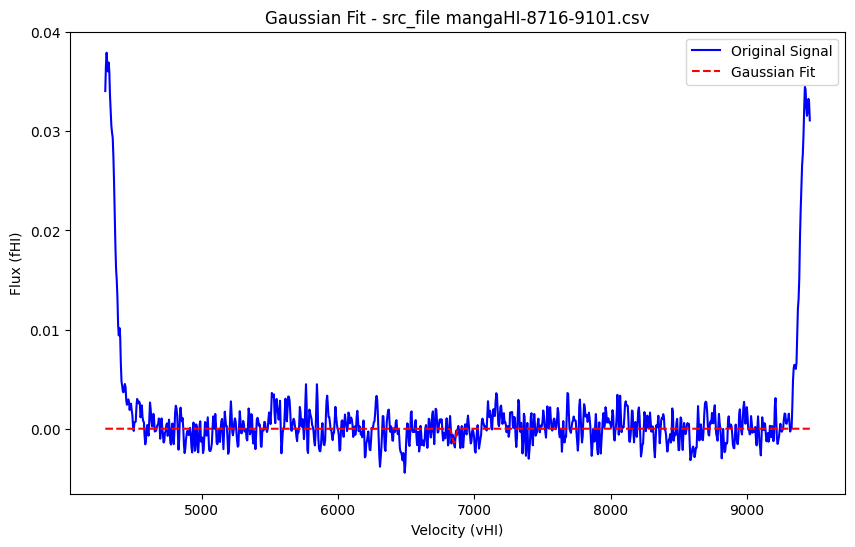